In [4]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.wavefunctions
import module.misc.cutoffs as cutoffs

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import netket.nn.activation
import pickle

import netket as nk

from scipy.sparse.linalg import eigsh

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/ewonisch/NeuralQuantumStates/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
key = jax.random.PRNGKey(0)

#### Trees

In [11]:
# this sums all square elements of a tree
euclid_norm_sq = lambda v: jax.tree_util.tree_reduce(lambda c,d : c + d, jax.tree_util.tree_map(lambda a: jnp.sum(a**2), v))

t_sum = lambda u,v: jax.tree_util.tree_map(lambda x,y:x+y, u,v)
t_sub = lambda u,v: jax.tree_util.tree_map(lambda x,y:x-y, u,v)
t_mul = lambda u,v: jax.tree_util.tree_map(lambda x,y:x*y, u,v)
t_div = lambda u,v: jax.tree_util.tree_map(lambda x,y:x/y, u,v)
s_mul = lambda s,v: jax.tree_util.tree_map(lambda x: s*x, v)

## Hamiltonian

$$
H = -h\sum_{i}S_i^{(x)} + J \sum_{<i,j>} S_i^{(z)} S_j^{(z)}
$$

In [12]:
# Define a grid
L = 4
g = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

# The number of sites (called nodes):
print("g.n_nodes:", g.n_nodes)
# You can iterate through the nodes:
print("g.nodes:", [node for node in g.nodes()])
# You can check the number of edges:
print("g.n_edges:", g.n_edges)
# You can iterate through the edges, which are stored as a 2-tuple with the start and end node:
print("g.edges:", g.edges())

# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

# This creates an empty operator (or zero) to which you can add others.
h = 1.
J = 1.

hamiltonian = nk.operator.LocalOperator(hi)

# now add all terms acting on single sites
for site in g.nodes():
    hamiltonian = hamiltonian - h* nk.operator.spin.sigmax(hi, site)

    # now add all terms acting on multiple sites
for (i,j) in g.edges():
    hamiltonian = hamiltonian + J * nk.operator.spin.sigmaz(hi, i) @ nk.operator.spin.sigmaz(hi, j)


hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()

g.n_nodes: 16
g.nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
g.n_edges: 32
g.edges: [(3, 7), (12, 13), (8, 9), (8, 12), (2, 14), (13, 14), (4, 5), (5, 6), (4, 8), (12, 15), (5, 9), (14, 15), (3, 15), (8, 11), (0, 1), (9, 10), (1, 2), (0, 4), (9, 13), (10, 11), (1, 5), (10, 14), (6, 7), (6, 10), (4, 7), (0, 3), (0, 12), (2, 3), (1, 13), (2, 6), (11, 15), (7, 11)]


In [13]:
ha = hamiltonian.to_sparse()
e_gs, psi_gs = eigsh(ha, k=1, which = "SA")
E_f = e_gs[0]
psi_gs = psi_gs.reshape(-1)

In [14]:
def calc_H_loc(orbital, parameters, samples):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(samples)
    
    logpsi_sigma = orbital.calc_logpsi(parameters, samples)
    logpsi_eta = orbital.calc_logpsi(parameters, eta)
    logpsi_sigma = jnp.expand_dims(logpsi_sigma, -1) 
    
    res = jnp.sum(H_sigmaeta * jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)
    
    return res

## Construct Neural Network

In [15]:
def act(x):
    return netket.nn.activation.log_cosh(x)

In [16]:
class NN(nn.Module):
    """
    Constructs a neural network.

    possible activation functions:
    netket.nn.activation.log_cosh(x)
    nn.softplus()
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(16, name="dense1", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(x)
        x = jnp.sum(x, axis = -1)

        return jnp.squeeze(x)

## Construct Ansatz

In [17]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (g.n_nodes,))

        self.nn = NN()


    def init_param(self, key):
        nn_param = self.nn.init(key, jnp.empty((g.n_nodes,)))

        return {"nn": nn_param}
    
    
    def calc_logpsi(self, parameters, x):
        logpsi = self.nn.apply(parameters["nn"], x)

        return logpsi

In [18]:
ansatz = Ansatz()
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

## Sampler

In [19]:
class FlipSampler(module.samplers.MCMC):
    def propose(self, key, element):
        subkey, _ = jax.random.split(key)

        mask = jnp.ones((g.n_nodes))
        for i in range(self.variance):
            index = jax.random.randint(key, (), 0, g.n_nodes)
            key, _ = jax.random.split(key)
            mask = mask.at[index].multiply(-1)

        proposal = element * mask

        return subkey, proposal
sampler = FlipSampler(ansatz, 1)
subsampling = g.n_nodes
def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, 2*jax.random.randint(key, (g.n_nodes,), 0, 2)-1 + 0., N*subsampling)
    return samples[0:-1:subsampling], ratio

## Optimisation

### Gradient of Energy and Metric Tensor

In [20]:
@partial(jax.jit, static_argnames=['orbital'])
def calc_grad_E(orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc.real)
    dE = jnp.std(E_loc.real)

    logpsi_red = lambda parameters: jnp.conjugate(orbital.calc_logpsi(parameters, samples))
    y, v = netket.jax.vjp(logpsi_red, parameters)
    N = samples.shape[0]

    m = lambda tree: 2*jnp.real(tree/N)

    return jax.tree_util.tree_map(m, v(E_loc - E))[0], E, dE

def eval_S1(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]

    a = jax.jvp(f, (parameters,), (v,))[1]
    b = netket.jax.vjp(f, parameters)[1](a)[0]
    return jax.tree_util.tree_map(lambda x: 1/N*x, b)

def eval_S2(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]
    e = jnp.ones(N)

    a = jnp.sum(jax.jvp(f, (parameters,), (v,))[1])
    b = netket.jax.vjp(f, parameters)[1](e)[0]
    return  jax.tree_util.tree_map(lambda v: 1/N**2 * a * v, b)

def eval_S(orbital, parameters, samples, v):
    s1 = eval_S1(orbital, parameters, samples, v)
    s2 = eval_S2(orbital, parameters, samples, v)
    return jax.tree_util.tree_map(lambda a,b: jnp.real(a-b), s1, s2)

eps = 1e-4
@partial(jax.jit, static_argnames=['ansatz'])
def apply_g(ansatz, samples, primals, tangent):
    u = eval_S(ansatz, primals, samples, tangent)
    return jax.tree_util.tree_map(lambda a, b: a + eps * b, u, tangent)

@partial(jax.jit, static_argnames=['ansatz'])
def inverse_g(ansatz, samples, primals, cotangent):
    A = lambda tangents : apply_g(ansatz, samples, primals, tangents)
    return jax.scipy.sparse.linalg.cg(A, cotangent)[0]

### Christoffel Symbols

In [21]:
def a_approx(ansatz, samples, gamma, old_gamma, gamma_dot, epsilon):
    x = s_mul(1/epsilon, t_sub(apply_g(ansatz, samples, gamma, gamma_dot), apply_g(ansatz, samples, old_gamma, gamma_dot)))
    return x

def a(ansatz, samples, primals, gamma_dot):
    f = lambda primals : apply_g(ansatz, samples, primals, gamma_dot)
    res = jax.jvp(f, (primals,), (gamma_dot,))
    return res[1]

def b(ansatz, samples, primals, gamma_dot):

    ## this sums all elements of a tree
    g = lambda v: jax.tree_util.tree_reduce(lambda c,d : c + d, jax.tree_util.tree_map(lambda a: jnp.sum(a), v))

    ## this computes the norm square of gamma dot
    f = lambda primals : g(jax.tree_util.tree_map(lambda c, d : c * d, gamma_dot, apply_g(ansatz, samples, primals, gamma_dot)))
    
    res = jax.vjp(f, primals)[1](jnp.array(1.))[0]
    return res

@partial(jax.jit, static_argnames=['ansatz'])
def geodesic_correction(ansatz, samples, primals, old_primals, gamma_dot, epsilon):
    lower = jax.tree_util.tree_map(lambda c,d: 2*c - 1*d, a_approx(ansatz, samples, primals, old_primals, gamma_dot, epsilon), b(ansatz, samples, primals, gamma_dot))
    return jax.tree_util.tree_map(lambda k:0.5*k, lower)

## Optimisation
The continuous time momentum equation will be discretised to obtain a recursive series, as one is familiar with for other optimisation algorithms.


The time derivatives can be discretised with finite differences. We take:

$$
\ddot{\gamma}(t) \approx \frac{1}{\epsilon^2}\left[\gamma(t + \epsilon) - 2 \gamma(t) + \gamma(t - \epsilon)\right]
$$

for the second derivative and
$$
\dot{\gamma}(t) \approx \frac{1}{\epsilon}\left[\gamma(t) - \gamma(t - \epsilon)\right]
$$
with $\epsilon$ being a small time step. The momentum equation becomes then:

$$
\gamma^i(t + \epsilon) = \gamma(t)^i - \epsilon^2g^{ij}\partial_j E + (1 - \kappa\epsilon)(\gamma^i(t) - \gamma^i(t-\epsilon)) - \Gamma^i_{jk}(\gamma^j(t)-\gamma^j(t-\epsilon))(\gamma^k(t)-\gamma^k(t-\epsilon))
$$

The momentum parameter $\beta$ is introduced via:
$$
\beta = 1- \kappa\epsilon
$$

In [22]:
stats = {"E":[], "dE":[], "ratio":[], "N_samples": [], "momentum":[], "grad": [], "cor":[], "param": [], "force":[]}
param = ansatz.init_param(key)

In [23]:
N = 5000
epoch = 100

beta = 0.9
epsilon = 0.01
kappa = (1 - beta) / epsilon
print("kappa =", kappa)


samples = get_samples(N)[0]
grad, E, dE = calc_grad_E(ansatz, param, samples)
initial_gradient = inverse_g(ansatz, samples, param, grad)
old_param = jax.tree_util.tree_map(lambda a, b: a + epsilon*b/kappa, param, initial_gradient) ## configure here the initial velocity

hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()

kappa = 9.999999999999998


In [24]:
for i in tqdm(range(epoch)):
    key, _ = jax.random.split(key)

    # samples
    samples, ratio = get_samples(N)

    # gradient and geodesic covectors
    grad, E, dE = calc_grad_E(ansatz, param, samples)
    param_dot = s_mul(1/epsilon, t_sub(param, old_param))
    cor = geodesic_correction(ansatz, samples, param, old_param, param_dot, epsilon)
    coforce = jax.tree_util.tree_map(lambda c, d: epsilon**2 * (c + d), grad, cor)
    force = inverse_g(ansatz, samples, param, coforce)

    # update
    new_param = jax.tree_util.tree_map(lambda par, old_par, forc: par - forc + (1 - kappa*epsilon) * (par - old_par), param, old_param, force)
    old_param = param
    param = new_param
    
    # store statistics
    stats["E"].append(E)
    stats["dE"].append(dE)
    stats["ratio"].append(ratio)
    stats["N_samples"].append(N)

    ## 2-norm of a pytree
    stats["momentum"].append(euclid_norm_sq(param_dot))
    stats["cor"].append(euclid_norm_sq(cor))
    stats["grad"].append(euclid_norm_sq(grad))
    stats["param"].append(euclid_norm_sq(param))
    stats["force"].append(euclid_norm_sq(force))


100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


(1e-08, 1e+20)

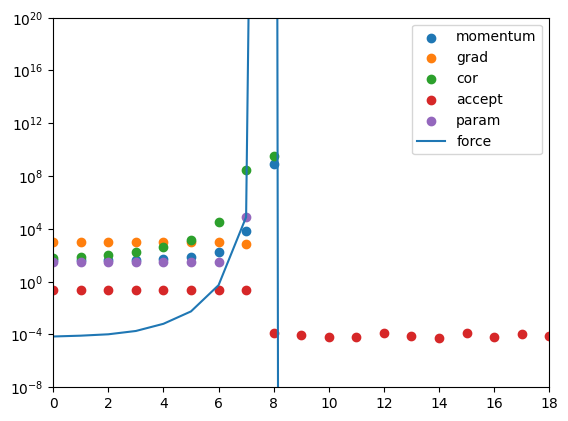

In [28]:
numpy_stats = {}
for key_ in stats.keys():
    numpy_stats[key_] = np.array(stats[key_])

i = np.arange(len(stats["E"]))
plt.scatter(i, numpy_stats["momentum"], label = "momentum")
plt.scatter(i, numpy_stats["grad"], label = "grad")
plt.scatter(i, numpy_stats["cor"], label = "cor")
plt.scatter(i, numpy_stats["ratio"], label = "accept")
plt.scatter(i, numpy_stats["param"], label = "param")
plt.plot(i, numpy_stats["force"], label = "force")
plt.legend()
plt.yscale("log")
plt.xlim(0,18)
plt.ylim(1e-8,1e20)

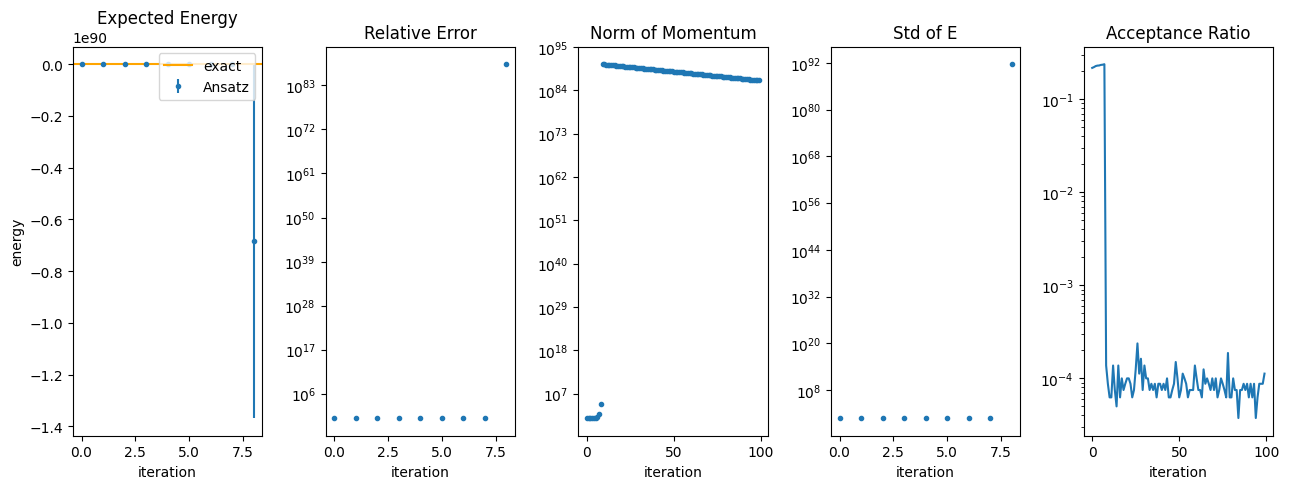

In [26]:
numpy_stats = {}
for key_ in stats.keys():
    numpy_stats[key_] = np.array(stats[key_])

f, ax = plt.subplots(1, 5, figsize = (13, 5))
i = np.arange(len(stats["E"]))

ax[0].errorbar(i, numpy_stats["E"], yerr = numpy_stats["dE"]/jnp.sqrt(numpy_stats["N_samples"]), fmt = ".", label = "Ansatz")
ax[0].set_title("Expected Energy")
ax[0].axhline(E_f, label = "exact", color = "orange")
ax[0].legend(loc = "upper right")
# ax[0].set_ylim(E_f-0.2, E_f+3)
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("energy")

ax[1].scatter(i, jnp.abs(numpy_stats["E"]-E_f)/-E_f , label = "error", marker = ".")
ax[1].set_title("Relative Error")
ax[1].set_yscale("log")
# ax[1].set_xscale("log")
ax[1].set_xlabel("iteration")

ax[2].scatter(i, np.sqrt(stats["momentum"]), marker = ".")
ax[2].set_title("Norm of Momentum")
ax[2].set_yscale("log")
ax[2].set_xlabel("iteration")

ax[3].scatter(i, stats["dE"], marker = ".")
ax[3].set_title("Std of E")
ax[3].set_yscale("log")
ax[3].set_xlabel("iteration")

ax[4].plot(stats["ratio"])
ax[4].set_title("Acceptance Ratio")
ax[4].set_xlabel("iteration")
ax[4].set_yscale("log")

f.tight_layout()


In [136]:
N = 30000
key, _ = jax.random.split(key)
samples, ratio = get_samples(N)
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
H_loc = calc_H_loc(ansatz, param, samples).real
print("Acceptance Ratio:\t", ratio)
print("Expected Energy:\t\t", jnp.mean(H_loc),"+/-", jnp.std(H_loc)/jnp.sqrt(N))
print("Ground Truth:\t\t\t", E_f)
print("Energy Error:\t\t", (jnp.mean(H_loc) - E_f)/jnp.abs(E_f))
print("Std of Expected Energy:\t", jnp.std(H_loc))

Acceptance Ratio:	 0.03195208333333333
Expected Energy:		 -33.995465324148725 +/- 0.002037246827903405
Ground Truth:			 -34.01059755084618
Energy Error:		 0.0004449268106751241
Std of Expected Energy:	 0.35286150134872263


In [137]:
all_states = jnp.array([state for state in hi.states()])
psi = ansatz.calc_psi(param, all_states)

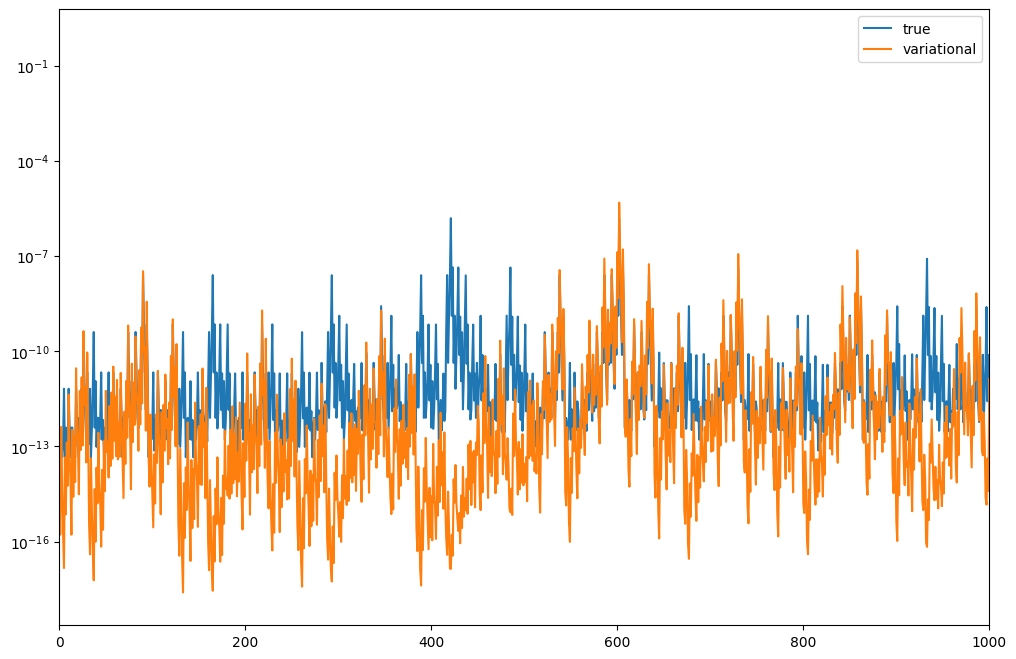

In [141]:
plt.figure(figsize=(12,8))
plt.plot(jnp.abs(psi_gs)**2, label="true")
plt.plot(jnp.abs(psi)**2/jnp.sum(jnp.abs(psi)**2), label = "variational")
plt.yscale("log")
# plt.xlim(0,1000)
plt.legend()

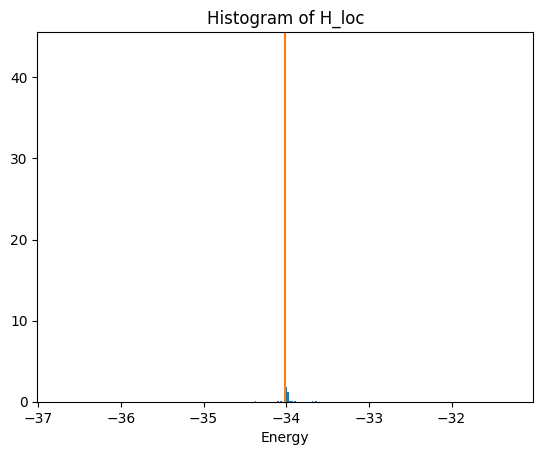

In [29]:
plt.hist(H_loc, bins=500, density=True)
plt.axvline(E_f, color = "C1")
# plt.ylim(0,20)
plt.title("Histogram of H_loc")
plt.xlabel("Energy")
plt.xlim(E_f - 3, E_f + 3)
pass

---